In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sqlite3
import seaborn as sns
from dataclasses import dataclass, field
from typing import Dict, Tuple, Iterable
from Utils.Plot_Helper import plot_1d_data, plot_gaussian_node
from Utils.Metrics import rmse, nll, node_metrics
from Filters.KalmanFilter import KalmanFilterSmoother
from Systems import UniformNonlinearGrowthModel, BearingsOnlyTracking, BearingsOnlyTrackingTurn
from MomentMatching.Estimator import Estimator
from MomentMatching import UnscentedTransform, MonteCarloTransform, TaylorTransform
from ExpectationPropagation.Nodes import build_nodes, node_estimator, node_system
from ExpectationPropagation.Iterations import ep_iterations
from Experiments.FullSweep import select_transform
from copy import deepcopy

In [3]:
def plot_smoother_results(nodes_list, iter_list, rmse_list, nll_list, ground_truth, vmin=None, vmax=None, colors=['C0', 'C2'], figsize=None):
    fig, axs = plt.subplots(len(nodes_list), figsize=figsize)
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    for i, params in enumerate(zip(nodes_list, iter_list, rmse_list, nll_list)):
        nodes, iter, rmse, nll = params
        ax = plot_gaussian_node(nodes, ground_truth, ax=axs[i], colors=colors)
        ax.set_title(f"(Iteration {iter+1}) RMSE={rmse:.2f}, NLL={nll:.2f}", fontsize=16)
        if i == len(nodes_list)-1:
            ax.set_xlabel("Time steps", fontsize=16)
        ax.set_ylim(vmin, vmax)
        ax.set_xlim(1, timesteps)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        if i == 0:
            ax.legend(loc='upper right', bbox_to_anchor=(1.04, 1.0), ncol=2, fontsize=12)
    plt.tight_layout()

    return ax

In [4]:
system = UniformNonlinearGrowthModel()
timesteps = 100
sys_dim = 1
SEED = 801

np.random.seed(seed=SEED)
data = system.simulate(timesteps)
x_true, x_noisy, y_true, y_noisy = zip(*data)

# Build EP nodes
num_samples = int(1e4)
trans_id = 'UT'
power = 0.1
damping = 0.4
transform, meas_transform = select_transform(trans_id, dim=sys_dim, samples=num_samples)
estim = Estimator(trans_map=transform,
                meas_map=meas_transform,
                trans_noise=system.transition_noise.cov,
                meas_noise=system.measurement_noise.cov,
                power=power,
                damping=damping)

nodes = build_nodes(N=timesteps, dim=sys_dim)
nodes = node_estimator(nodes=nodes, estimator=estim)
nodes = node_system(nodes=nodes, system_model=system, measurements=y_noisy)


# Run EP iteration
max_iter = 50
iters = [0, 9, 49]
nodes_to_plot = []
rmse_list, nll_list = [], []
for i in range(max_iter):
    for node in nodes:
        node.fwd_update()
        node.meas_update()
    for node in reversed(nodes):
        node.back_update()
    if i in iters:
        nodes_to_plot.append(deepcopy(nodes))
        rmse_, nll_ = node_metrics(nodes, x_noisy)
        rmse_list.append(rmse_)
        nll_list.append(nll_)

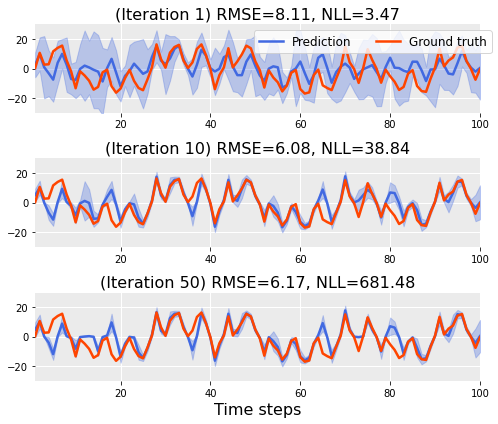

In [5]:
ax = plot_smoother_results(nodes_to_plot, iters, rmse_list, nll_list, x_noisy, figsize=(7,6), vmin=-30, vmax=30, colors=['royalblue', 'orangered'])
# ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1.1), ncol=2)
plt.savefig(f"figs/Smoother_results_power_{power}_damp_{damping}.pdf")